## 图像抽取

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import sys
sys.path.append('../data/')
sys.path.append("../")
from load_cifar import load_cifar
from load_olivetti import load_olivetti
from resnet import resnet
from preact_resnet import PreActResNet18
import matplotlib.pyplot as plt

In [2]:
os.listdir('ckpts/')

['olivetti_cap_resnet_4_model.ckpt',
 'cifar_cap_res5_0.2_model.ckpt',
 'cifar_cap_res5_0.4_model.ckpt',
 'cifar_no_preact_resnet_model.ckpt',
 'cifar_cap_res5_0.1_model.ckpt',
 'cifar_cap_preact_resnet_0.1_model.ckpt',
 'olivetti_cap_resnet_2_model.ckpt',
 '.ipynb_checkpoints',
 'olivetti_no_res5_model.ckpt',
 'olivetti_cap_resnet_1_model.ckpt',
 'cifar_cap_preact_resnet_0.4_model.ckpt',
 'olivetti_cap_preact_1_model.ckpt',
 'cifar_no_res5_model.ckpt',
 'olivetti_cap_preact_4_model.ckpt',
 'olivetti_cap_preact_2_model.ckpt',
 'olivetti_no_preact_model.ckpt',
 'cifar_cap_preact_resnet_0.2_model.ckpt']

In [3]:
# 加载数据
def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    return X_train, y_train, X_test

def load_data(name='cifar'):
    if name == 'cifar':
        X_train, y_train, X_test, y_test = load_cifar(10)
        X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
        X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
        X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
        X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
    else:
        X_train, y_train, X_test, y_test = load_olivetti()
    return X_train, y_train, X_test, y_test

def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

def mal_data_synthesis(train_x, num_targets=10, precision=4):
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:     # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets

In [4]:
def data_to_loader(x, y, size=512):
    x_data = torch.from_numpy(x)
    y_data = torch.from_numpy(y).long()
    loader = DataLoader(dataset=TensorDataset(x_data, y_data), 
                          batch_size=size, 
                          shuffle=False, 
                          num_workers=2)
    return loader

In [5]:
# 加载CIFAR10
X_train, y_train, X_test, y_test = load_data(name='cifar')
mal_x_8, mal_y_8, num_targets = mal_data_synthesis(X_train, num_targets=8)
mal_x_18, mal_y_18, num_targets = mal_data_synthesis(X_train, num_targets=18)
mal_x_38, mal_y_38, num_targets = mal_data_synthesis(X_train, num_targets=38)
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
test_loader = data_to_loader(X_test, y_test)
mal_8_loader = data_to_loader(mal_x_8, mal_y_8)
mal_18_loader = data_to_loader(mal_x_18, mal_y_18)
mal_38_loader = data_to_loader(mal_x_38, mal_y_38)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def cap_reconstruct(net, path, loader):
    res = []
    net.load_state_dict(torch.load(path))
    net.eval()
    for i, data in enumerate(loader):
        x, y = data
        x = x.to(device)
        pred = net(x)
        res.append(pred.max(1)[1])
    res = torch.cat(res)
    res = res.reshape(-1, 2).sum(1).reshape(-1,32,32)*(2**4)
    return res

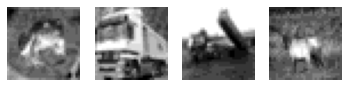

In [8]:
net = resnet(num_classes=10).to(device)
path = 'ckpts/cifar_cap_res5_0.1_model.ckpt'
res = cap_reconstruct(net, path, mal_8_loader)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')

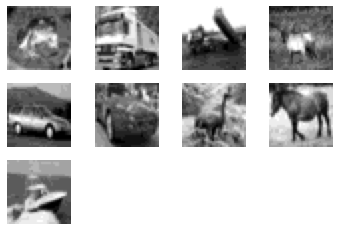

In [9]:
net = resnet(num_classes=10).to(device)
path = 'ckpts/cifar_cap_res5_0.2_model.ckpt'
res = cap_reconstruct(net, path, mal_18_loader)
for i in range(9):
    plt.subplot(3,4,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')

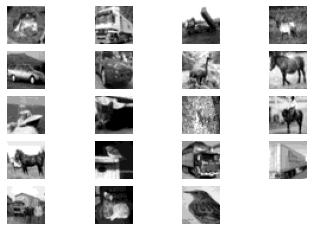

In [10]:
net = resnet(num_classes=10).to(device)
path = 'ckpts/cifar_cap_res5_0.4_model.ckpt'
res = cap_reconstruct(net, path, mal_38_loader)
for i in range(19):
    plt.subplot(5,4,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')

### Olivetti

In [11]:
# 加载Olivetti
X_train, y_train, X_test, y_test = load_data(name='olivetti')
mal_x_2, mal_y_2, num_targets = mal_data_synthesis(X_train, num_targets=2)
mal_x_4, mal_y_4, num_targets = mal_data_synthesis(X_train, num_targets=4)
mal_x_8, mal_y_8, num_targets = mal_data_synthesis(X_train, num_targets=8)
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
test_loader = data_to_loader(X_test, y_test)
mal_2_loader = data_to_loader(mal_x_2, mal_y_2)
mal_4_loader = data_to_loader(mal_x_4, mal_y_4)
mal_8_loader = data_to_loader(mal_x_8, mal_y_8)

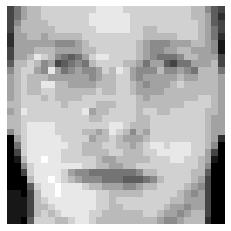

In [12]:
net = resnet(num_classes=40).to(device)
path = 'ckpts/olivetti_cap_resnet_1_model.ckpt'
res = cap_reconstruct(net, path, mal_2_loader)
for i in range(1):
    plt.subplot(1,1,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')

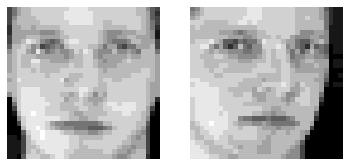

In [13]:
net = resnet(num_classes=40).to(device)
path = 'ckpts/olivetti_cap_resnet_2_model.ckpt'
res = cap_reconstruct(net, path, mal_4_loader)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')

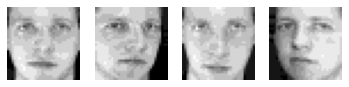

In [14]:
net = resnet(num_classes=40).to(device)
path = 'ckpts/olivetti_cap_resnet_4_model.ckpt'
res = cap_reconstruct(net, path, mal_8_loader)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(res[i].cpu(), cmap='gray')
    plt.axis('off')